## The purpose

Understanding what role certain properties of a product play and how they affect the sales is imperative to any retail business.Therefore, the aim here is to predict the future sales and help in getting an idea about future demands that can help with inventory management..

In [1]:
!pip install xgboost

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer,mean_squared_error, r2_score, mean_absolute_error


import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')

In [3]:
df = pd.read_csv('SupermarketSalesData.csv')
df.head(3)

,item_id,item_weight,item_fat,item_visibility,item_category,item_market_price,outlet_id,outlet_establishment_year,outlet_size,outlet_location,outlet_type,item_outlet_sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700


In [4]:
df.tail(3)

,item_id,item_weight,item_fat,item_visibility,item_category,item_market_price,outlet_id,outlet_establishment_year,outlet_size,outlet_location,outlet_type,item_outlet_sales
8520,NCJ29,10.60,Low Fat,0.035186,Health and Hygiene,85.1224,OUT035,2004,Small,Tier 2,Supermarket Type1,1193.1136
8521,FDN46,7.21,Regular,0.145221,Snack Foods,103.1332,OUT018,2009,Medium,Tier 3,Supermarket Type2,1845.5976
8522,DRG01,14.80,Low Fat,0.044878,Soft Drinks,75.4670,OUT046,1997,Small,Tier 1,Supermarket Type1,765.6700


In [5]:
df.shape

(8523, 12)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   item_id                    8523 non-null   object 
 1   item_weight                8523 non-null   float64
 2   item_fat                   8523 non-null   object 
 3   item_visibility            8523 non-null   float64
 4   item_category              8523 non-null   object 
 5   item_market_price          8523 non-null   float64
 6   outlet_id                  8523 non-null   object 
 7   outlet_establishment_year  8523 non-null   int64  
 8   outlet_size                6113 non-null   object 
 9   outlet_location            8523 non-null   object 
 10  outlet_type                8523 non-null   object 
 11  item_outlet_sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


**Overview**

- The dataset has **8523 observations and 12 features**. 
- One feature the **outlet size** has missing values as the number of non-null values is less than the total number of observations for this feature.
- We observe that the columns **item fat**, **item category**, **outlet size**, **outlet location**, and **outlet type** have data type **object**, which means they are categorical features, we need to handle them later on.
- The remaining features are all numerical in nature.

In [7]:
(df.isnull().sum() / df.shape[0])*100

item_id                       0.000000
item_weight                   0.000000
item_fat                      0.000000
item_visibility               0.000000
item_category                 0.000000
item_market_price             0.000000
outlet_id                     0.000000
outlet_establishment_year     0.000000
outlet_size                  28.276428
outlet_location               0.000000
outlet_type                   0.000000
item_outlet_sales             0.000000
dtype: float64

- The percentage of missing values for the outlet size is **28%**.

# **EDA and Data Preprocessing**

## 1. Data Preprocessing


*Before we move ahead with the exploratory data analysis, let's first fix the data issues that we have found for these categorical variables..*

In [8]:
copied_df = df.copy()

### #Fixing The Inconsistent Values

- **item fat**


Obviously, the item fat only has 2 categories (Low Fat or Regular).


First, we need to replace the categories - low fat and LF by Low Fat using lambda function and also we are replacing the category reg by Regular.Then, we can label these two categories to (0 - 1).

In [9]:
df['item_fat'] = df['item_fat'].apply(lambda x: 'Low Fat' if x == 'low fat' or x == 'LF' else x)
df['item_fat'] = df['item_fat'].apply(lambda x: 'Regular' if x == 'reg' else x)

In [10]:
#Check
df['item_fat'].unique()

array(['Low Fat', 'Regular'], dtype=object)

### #Feature Engineering

- **Oulet Age**

In [11]:
df['outlet_age'] = 2023 - df['outlet_establishment_year']

### #Handling The Missing/Null Values

We will be imputing missing values for the column **outlet_size**. 

Below, we are creating two different datasets - one where we have non-null values for the column **outlet_size** and in the other dataset, all the values of the column **outlet_size** are missing.

In [12]:
outlet_size_data = df[df['outlet_size'].notnull()]
outlet_size_missing_data = df[df['outlet_size'].isnull()]

Now let's see the proportions of the missing/null values by outlet type, outlet location & item fat:

In [13]:
outlet_size_missing_data['outlet_type'].value_counts(normalize=True).round(2)

Supermarket Type1    0.77
Grocery Store        0.23
Name: outlet_type, dtype: float64

In [14]:
outlet_size_missing_data['outlet_location'].value_counts(normalize=True).round(2)

Tier 2    0.77
Tier 3    0.23
Name: outlet_location, dtype: float64

In [15]:
outlet_size_missing_data['item_fat'].value_counts(normalize=True).round(2)

Low Fat    0.65
Regular    0.35
Name: item_fat, dtype: float64

**Insight**

- We can see that, wherever **outlet size** is missing in the dataset, the majority of them have **outlet type** as Supermarket Type 1 **(77%)**, **outlet location** as Tier 2 **(77%)** and Tier 3 **(23%)** , and **item fat** as Low Fat **(65%)**.

We check the distribution of the other variables in the dataset where **outlet_size** is missing to identify if there is any pattern present or not.

**1. outlet type vs. outlet size**

<AxesSubplot:xlabel='outlet_size', ylabel='outlet_type'>

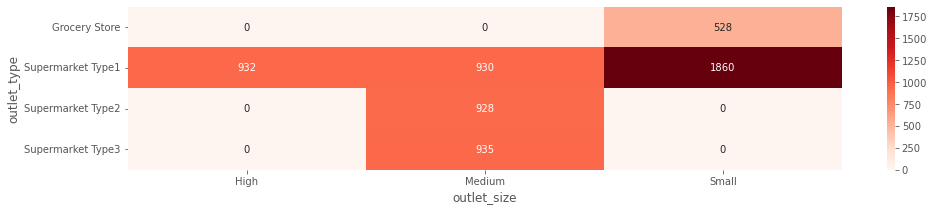

In [16]:
fig= plt.figure(figsize=(16, 3))

sns.heatmap(pd.crosstab(index = outlet_size_data['outlet_type'], columns = outlet_size_data['outlet_size']), annot = True, fmt = 'g', cmap='Reds')

**Insighs**
-  We observe from the above heatmap that all the grocery stores have outlet size as **small**.
- All the Supermarket Type 2 and Supermarket Type 3 have outlet size as **medium**.

**2. outlet location vs. outlet size**

<AxesSubplot:xlabel='outlet_size', ylabel='outlet_location'>

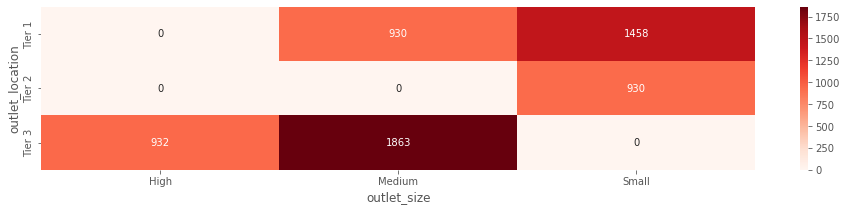

In [17]:
fig= plt.figure(figsize=(16, 3))

sns.heatmap(pd.crosstab(index = outlet_size_data['outlet_location'], columns = outlet_size_data['outlet_size']), annot = True, fmt = 'g', cmap='Reds')

**Insight**

- We observed that whenever the **outlet size** is High, the **outlet location** is based on Tier3.

**3. item fat vs. outlet size**

<AxesSubplot:xlabel='outlet_size', ylabel='item_fat'>

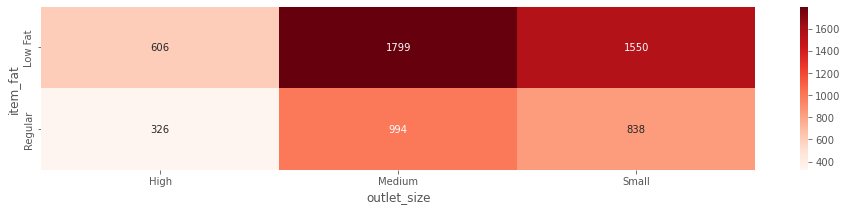

In [18]:
fig= plt.figure(figsize=(16, 3))

sns.heatmap(pd.crosstab(index = outlet_size_data['item_fat'], columns = outlet_size_data['outlet_size']), annot = True, fmt = 'g', cmap='Reds')

**Insight**

- There does not seem to be any clear pattern between the variables **item fat** and **outlet size**.

**Solution**

Now, we will use the patterns we have from the variable **outlet type** and **outlet location** to impute the missing values for the column **outlet size**.

And since there are overlaps between the outlet type and outlet location, we will use pivot table for a more detailed view.

In [19]:
pd.pivot_table(outlet_size_data, index= ['outlet_type', 'outlet_location', 'outlet_establishment_year', 'outlet_size'], 
               columns=None, values='outlet_id', aggfunc='count')

outlet_id
outlet_type       outlet_location outlet_establishment_year outlet_size           
Grocery Store     Tier 1          1985                      Small              528
Supermarket Type1 Tier 1          1997                      Small              930
                                  1999                      Medium             930
                  Tier 2          2004                      Small              930
                  Tier 3          1987                      High               932
Supermarket Type2 Tier 3          2009                      Medium             928
Supermarket Type3 Tier 3          1985                      Medium             935

- We observed that Supermarket Type 2 and 3 are medium size outlets based at Tier3, and outlets of the Supermarket Type 1 at Tier 2 are medium size outlets, and Tier 3 is high size outlets.

- The Grocery Store at Tier1 has small size outlets.

**1. Supermarket Type 1 , Tier2 , Small**

In [20]:
supermarket1_small_filter = df[df['outlet_size'].isnull()].query(" outlet_type == 'Supermarket Type1' & outlet_location == 'Tier 2'").index

In [21]:
df.loc[supermarket1_small_filter, 'outlet_size'] = 'Small'

**2. Supermarket Type 1 , Tier3 , High**

In [22]:
supermarket1_high_filter = df[df['outlet_size'].isnull()].query(" outlet_type == 'Supermarket Type1' & outlet_location == 'Tier 3'").index

In [23]:
df.loc[supermarket1_high_filter, 'outlet_size'] = 'High'

**3. Supermarket Type 1, Tier1 , Medium**

In [24]:
supermarket1_medium_filter = (df['outlet_size'].isnull()) & (df['outlet_location'] == 'Tier 1') & (df['outlet_type'] == 'Supermarket Type1') & (df['outlet_establishment_year'] == 1999)

In [25]:
df.loc[supermarket1_medium_filter, 'outlet_size'] = 'Medium'

**4. Supermarket Type 1, Tier1 , Small**

In [26]:
supermarket1_sm_filter = (df['outlet_size'].isnull()) & (df['outlet_location'] == 'Tier 1') & (df['outlet_type'] == 'Supermarket Type1') & (df['outlet_establishment_year'] == 1997)

In [27]:
df.loc[supermarket1_sm_filter, 'outlet_size'] = 'Small'

**5. Supermarket Type 2, Medium**

In [28]:
supermarket2_medium_filter = df[df['outlet_size'].isnull()].query(" outlet_type == 'Supermarket Type2'").index

In [29]:
df.loc[supermarket2_medium_filter, 'outlet_size'] = 'Medium'

**6. Supermarket Type 3, Medium**

In [30]:
supermarket3_medium_filter = df[df['outlet_size'].isnull()].query(" outlet_type == 'Supermarket Type3'").index

In [31]:
df.loc[supermarket3_medium_filter, 'outlet_size'] = 'Medium'

**7. Grocery Store, Small**

In [32]:
Grocery_Store_filter = df[df['outlet_size'].isnull()].query("outlet_type == 'Grocery Store' ").index

In [33]:
df.loc[Grocery_Store_filter, 'outlet_size'] = 'Small'

In [34]:
#Check
df.isnull().sum()

item_id                      0
item_weight                  0
item_fat                     0
item_visibility              0
item_category                0
item_market_price            0
outlet_id                    0
outlet_establishment_year    0
outlet_size                  0
outlet_location              0
outlet_type                  0
item_outlet_sales            0
outlet_age                   0
dtype: int64

### #Remove Unnecessary Variables 

We will drop all the variables that aren't very useful to our analysis, which’s the identifier columns.

In [35]:
df.drop(columns=['item_id', 'outlet_id', 'outlet_establishment_year'], inplace=True)

## 2. **EDA**

### #**Univariate Analysis**

**Summary Statistics**

In [36]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
item_weight,8523.0,12.794168,4.220152,4.555,9.100000,12.650000,16.725000,21.350000
item_visibility,8523.0,0.066132,0.051598,0.000,0.026989,0.053931,0.094585,0.328391
item_market_price,8523.0,140.992782,62.275067,31.290,93.826500,143.012800,185.643700,266.888400
item_outlet_sales,8523.0,2181.288914,1706.499616,33.290,834.247400,1794.331000,3101.296400,13086.964800
outlet_age,8523.0,25.168133,8.371760,14.000,19.000000,24.000000,36.000000,38.000000


**Insights**

- The AVG of the item weight is approx **13 kg**.
- The AVG of the item visibility is approx **66%**.
- The AVG of the item market price is approx **141 USD**, and deviates from the mean by **62.27 USD**.
- The AVG of the item outlet sales is **2182 USD**.
- The AVG of outlet age is **25**.

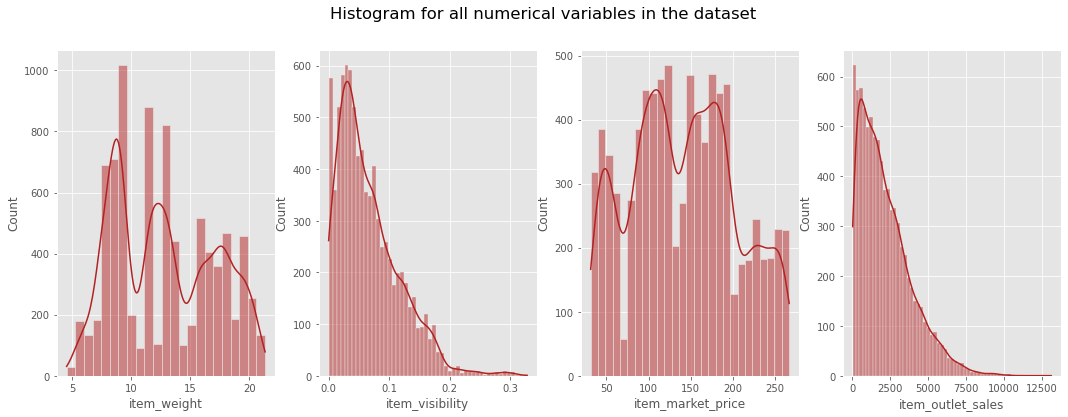

In [37]:
fig, axes = plt.subplots(1, 4, figsize = (18, 6))
  
fig.suptitle('Histogram for all numerical variables in the dataset', fontsize=16.5)
  
sns.histplot(x = 'item_weight', data = df, kde = True, ax = axes[0], color='#B22222');

sns.histplot(x='item_visibility', data = df, kde = True, ax = axes[1], color='#B22222');

sns.histplot(x='item_market_price', data = df, kde = True, ax = axes[2], color='#B22222');

sns.histplot(x='item_outlet_sales', data = df, kde = True, ax = axes[3], color='#B22222');

**Insights**

- item weight and item market price distribution is more like **uniform distribution**.
- item visibility and item outlet sales distribution is **right-skewed**.

**Summary of The Categorical Variables**

In [38]:
categorical_col = ['item_fat', 'item_category', 'outlet_size', 
                    'outlet_type', 'outlet_location']

for column in categorical_col:
    print(df[column].value_counts(normalize=True).round(2))
    print()
    print('--' * 25)
    print()

Low Fat    0.65
Regular    0.35
Name: item_fat, dtype: float64

--------------------------------------------------

Fruits and Vegetables    0.14
Snack Foods              0.14
Household                0.11
Frozen Foods             0.10
Dairy                    0.08
Canned                   0.08
Baking Goods             0.08
Health and Hygiene       0.06
Soft Drinks              0.05
Meat                     0.05
Breads                   0.03
Hard Drinks              0.03
Others                   0.02
Starchy Foods            0.02
Breakfast                0.01
Seafood                  0.01
Name: item_category, dtype: float64

--------------------------------------------------

Small     0.56
Medium    0.33
High      0.11
Name: outlet_size, dtype: float64

--------------------------------------------------

Supermarket Type1    0.65
Grocery Store        0.13
Supermarket Type3    0.11
Supermarket Type2    0.11
Name: outlet_type, dtype: float64

--------------------------------------------

**Insights**

- In this dataset, the items with low fat **(65%)** is more than the regular items **(35%)**.
- The proportion of fruits and vegetables and snack foods items are **(14%)**, then household and frozen foods items are **(11%)** and **(10%)** respectively, whereas seafood  items are the lowest **(1%)**.
- A lot of the outlets are small-sized **(56%)**.
- Supermarket Type1 **(65%)** is the dominant outlet type.
- Tier 3 **(39%)**  has a slightly bigger proportion than the other outlets location.

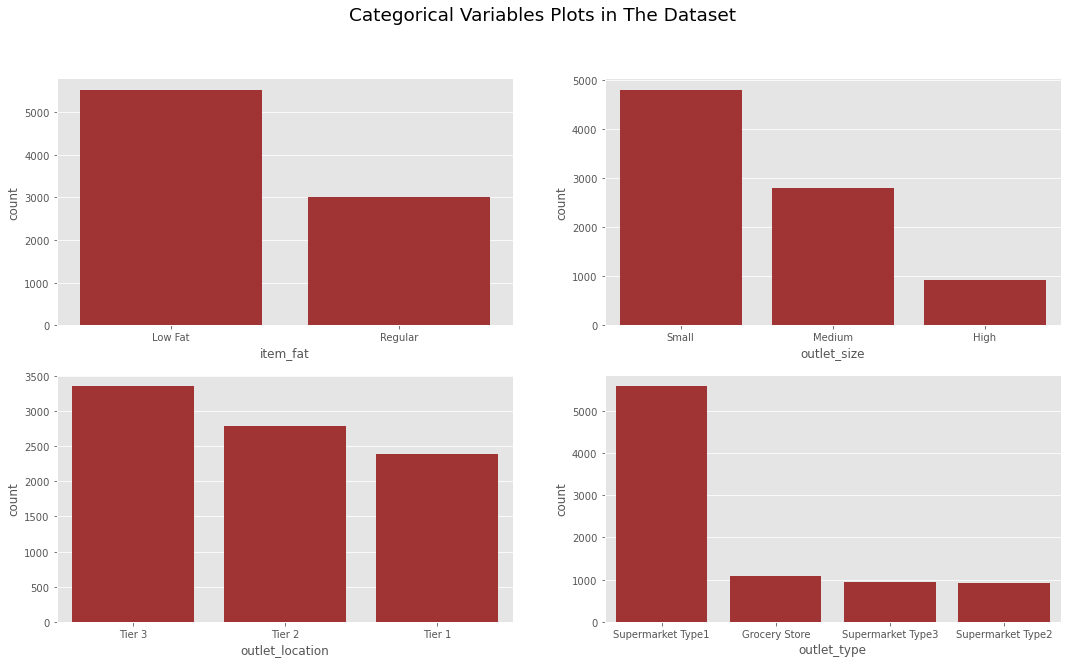

In [39]:
fig, axes = plt.subplots(2, 2, figsize = (18, 10))
  
fig.suptitle('Categorical Variables Plots in The Dataset', fontsize=18.5)

sns.countplot(ax = axes[0, 0], x = 'item_fat', data = df, color='#B22222',
              order = df['item_fat'].value_counts().index);

sns.countplot(ax = axes[0, 1], x = 'outlet_size', data = df, color='#B22222',  
              order = df['outlet_size'].value_counts().index);

sns.countplot(ax = axes[1, 0], x = 'outlet_location', data = df, color='#B22222',
              order = df['outlet_location'].value_counts().index);

sns.countplot(ax = axes[1, 1], x = 'outlet_type', data = df, color='#B22222',
              order = df['outlet_type'].value_counts().index);

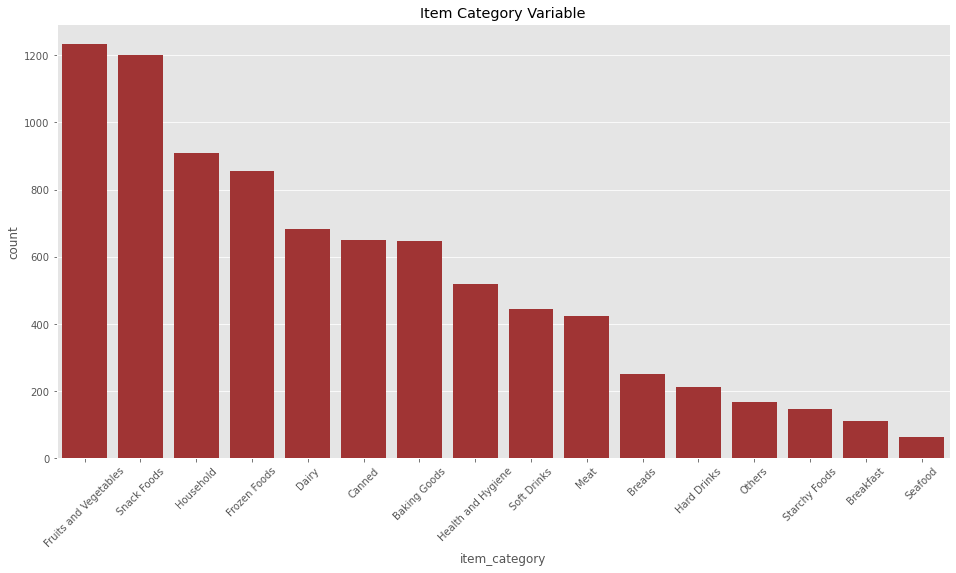

In [40]:
fig= plt.figure(figsize = (16, 8))

sns.countplot(x = 'item_category', data = df, color='#B22222', order = df['item_category'].value_counts().index);
plt.title('Item Category Variable')
plt.xticks(rotation = 45);

### #Bivariate Analysis

**Numerical Variables VS. Item Outlet Sales**

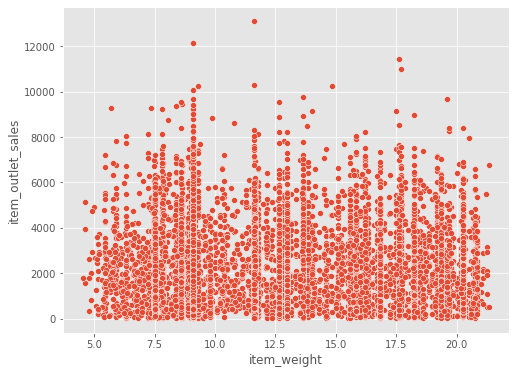

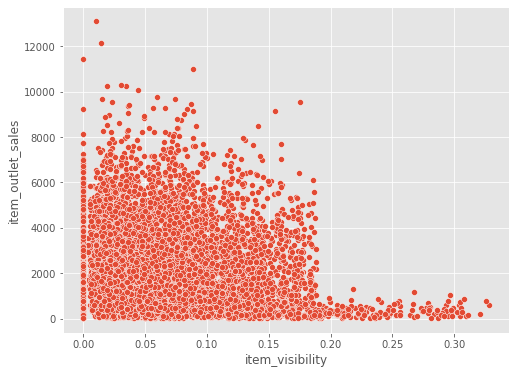

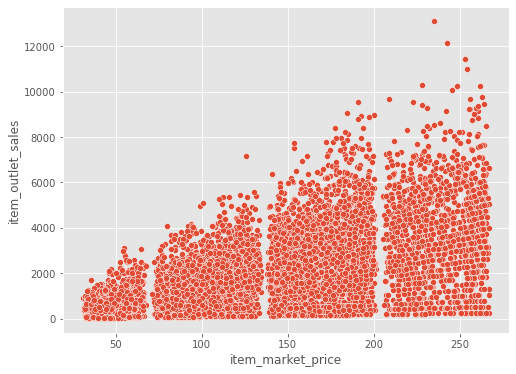

In [41]:
numeric_cols_ = ['item_weight','item_visibility', 'item_market_price']

for col in numeric_cols_:
    plt.figure(figsize = (8,6))
    sns.scatterplot(x = col , y = 'item_outlet_sales', data = df)
    plt.show()

**Insight**

As we observed from the scatter plots above:

- There's **a positive relationship** between the item market price and item sales.

**Categorical Variables VS. Item Outlet Sales**

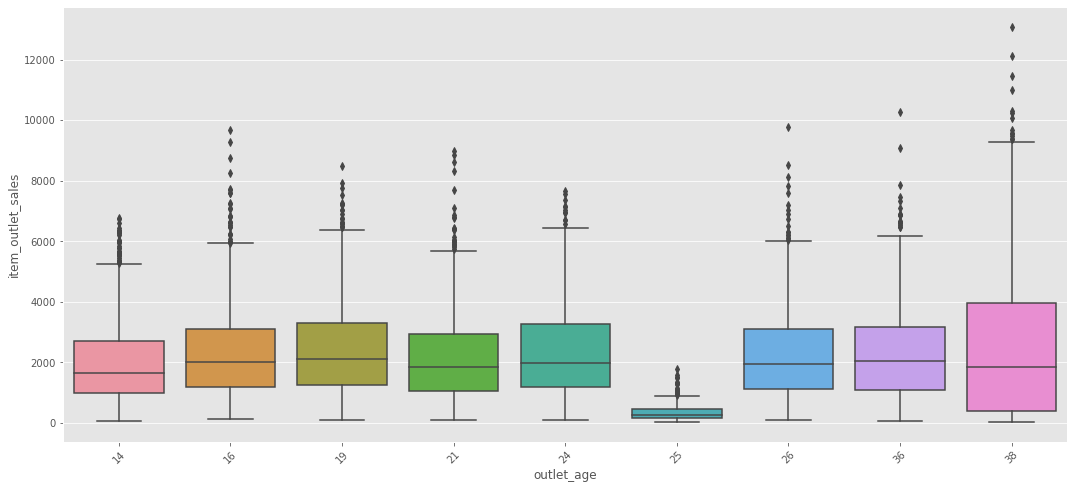

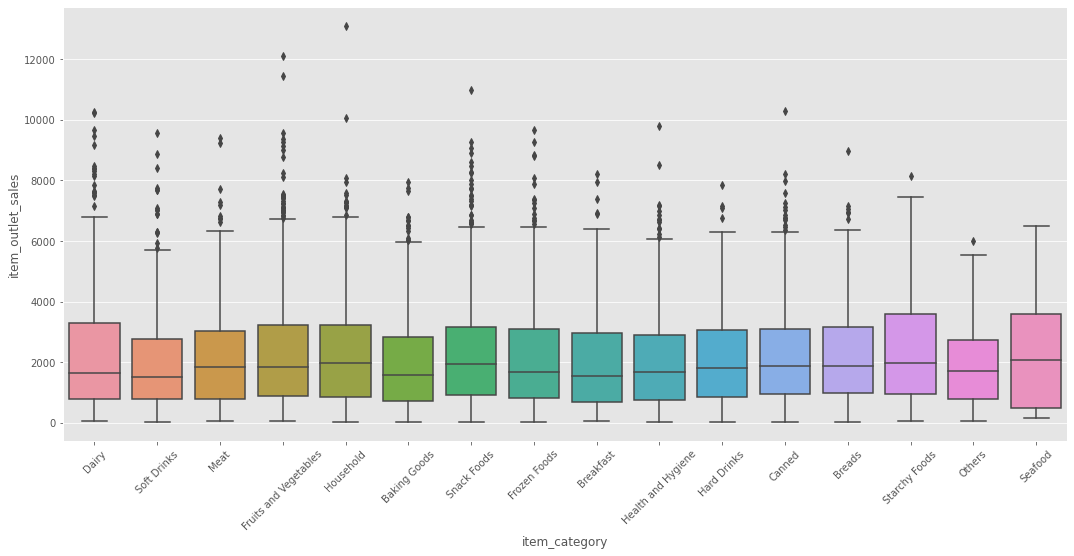

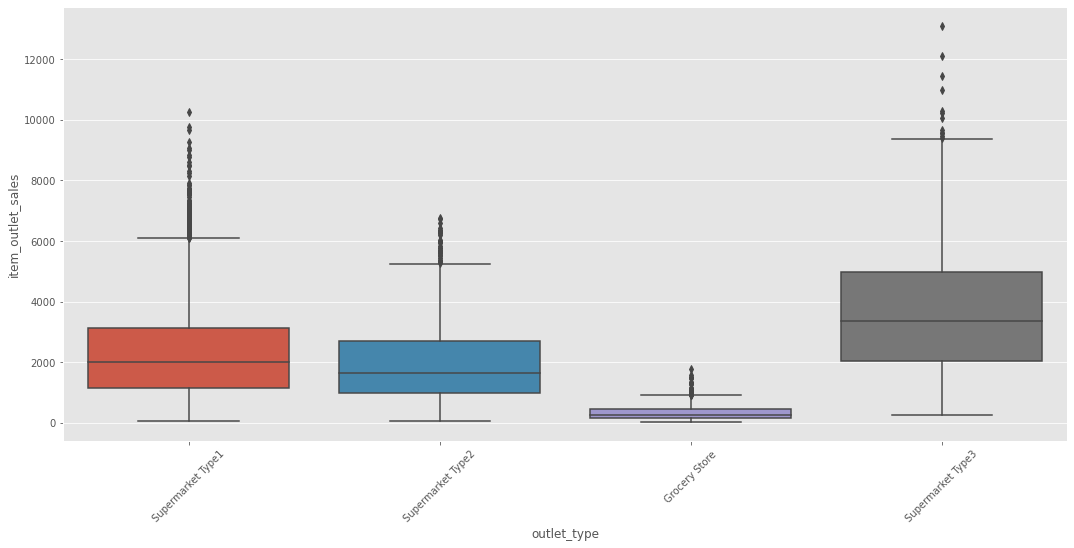

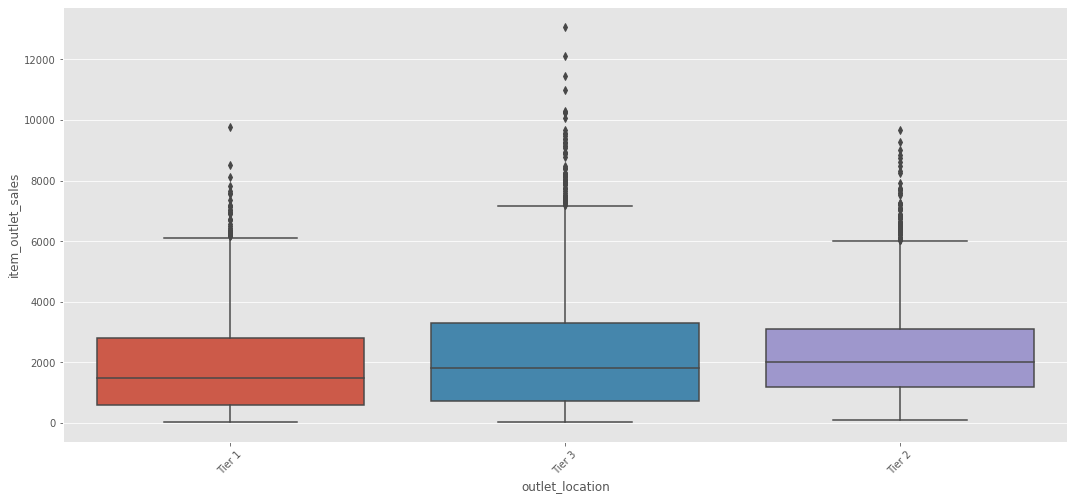

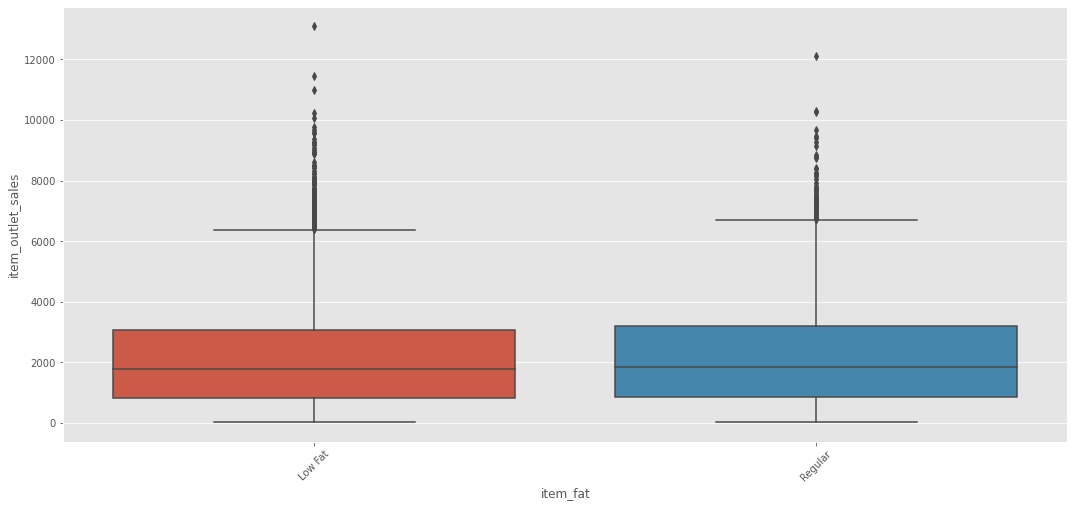

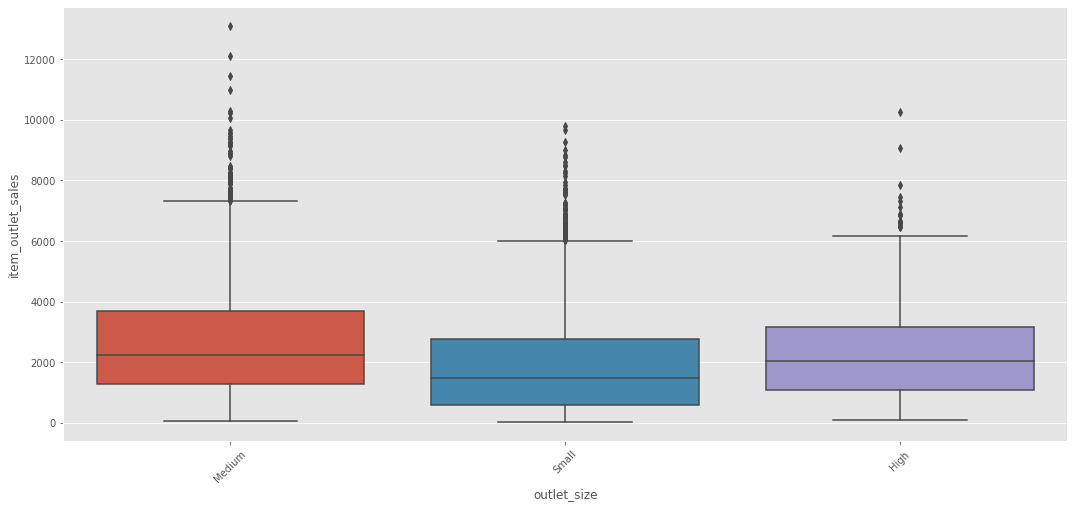

In [42]:
cat_cols_ = ['outlet_age', 'item_category', 'outlet_type', 'outlet_location', 'item_fat', 'outlet_size']

for col in cat_cols_:
    plt.figure(figsize = (18,8))
    sns.boxplot(x = col , y ='item_outlet_sales', data=df)
    plt.xticks(rotation = 45);
    plt.show()

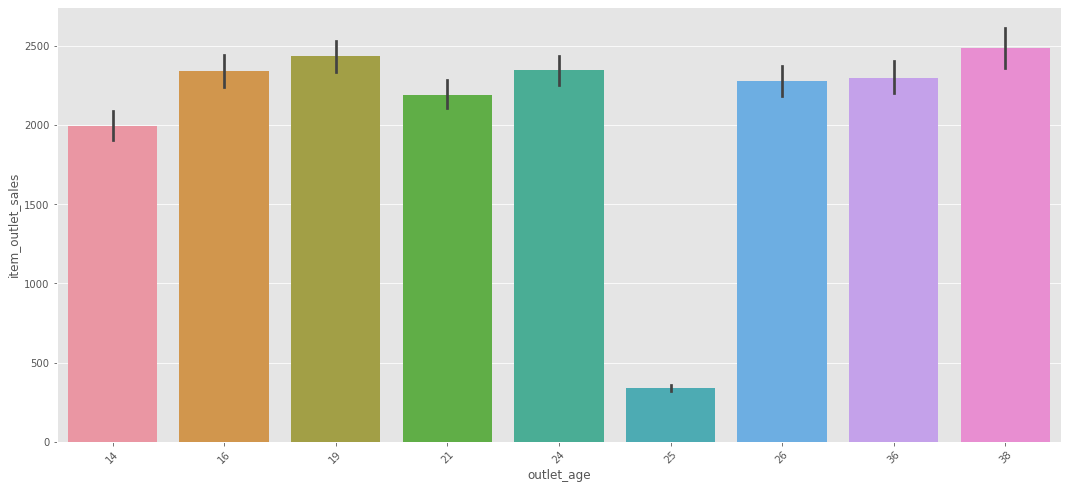

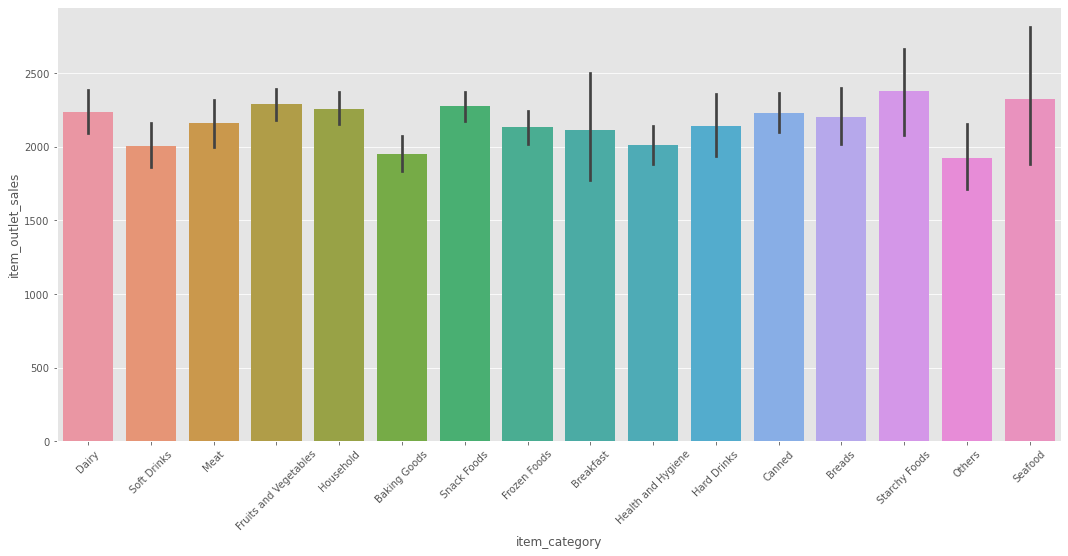

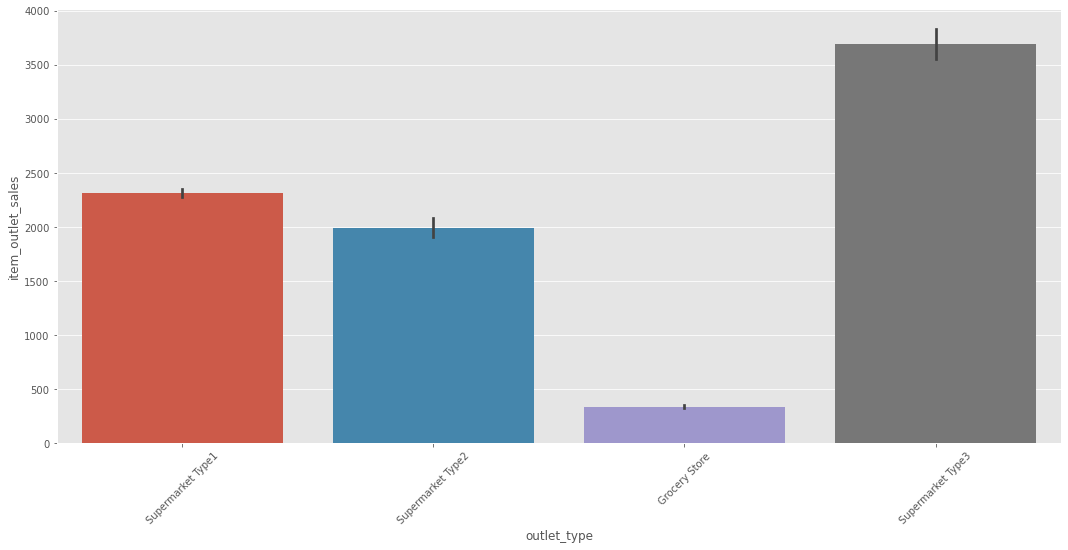

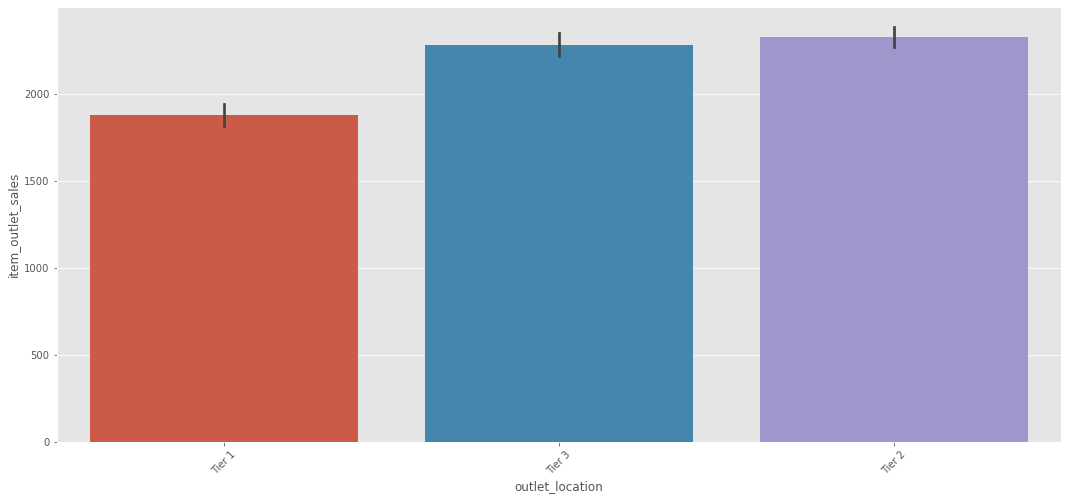

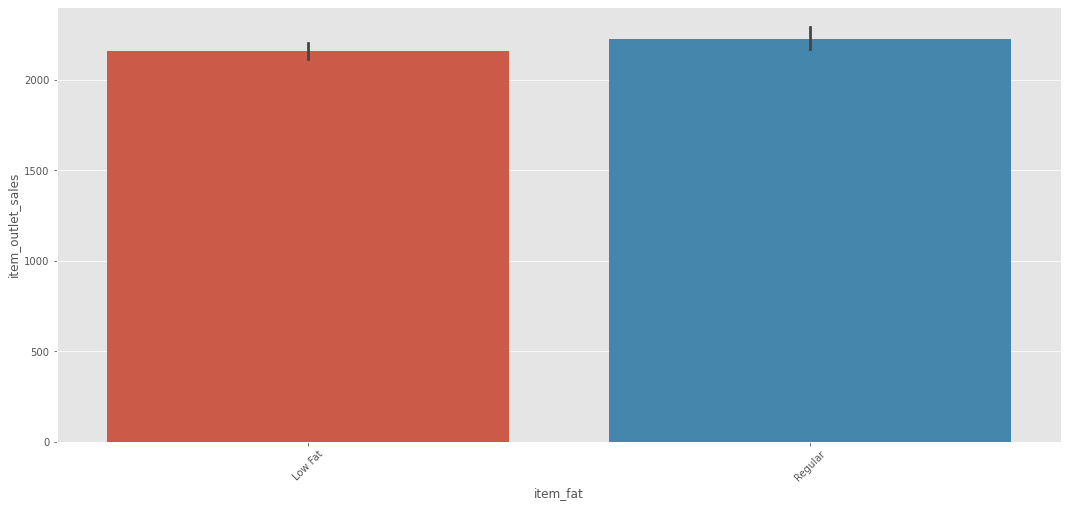

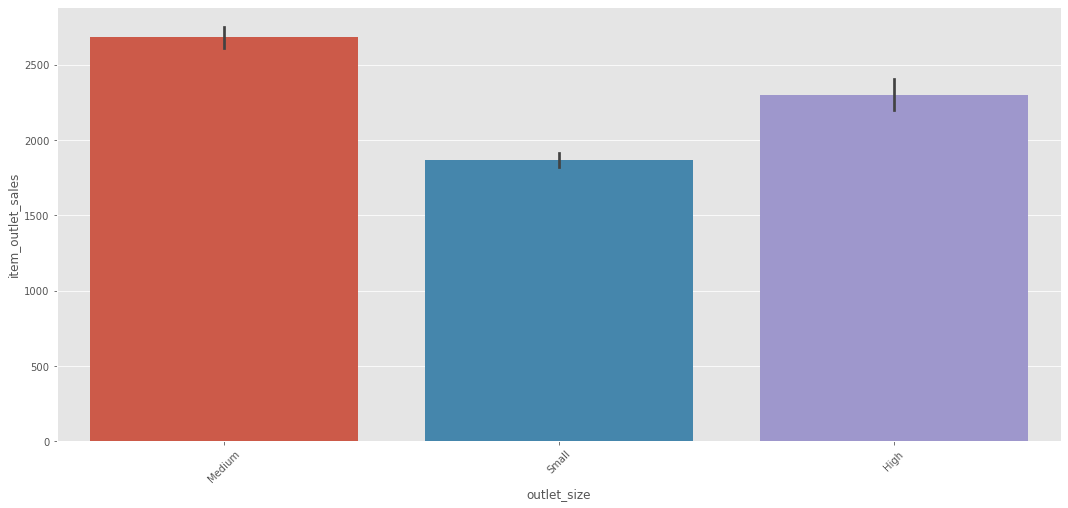

In [43]:
for col in cat_cols_:
    plt.figure(figsize = (18,8))
    sns.barplot(x = col , y ='item_outlet_sales', data=df)
    plt.xticks(rotation = 45);
    plt.show()

**Insight**

- As we can see there's high-sales within each categorical variable (outliers).
- The outlet with age 25 years has **the lowest amount of sales**.
- outlets from type grocery stores have **less sales than the other outlet types**.

<AxesSubplot:>

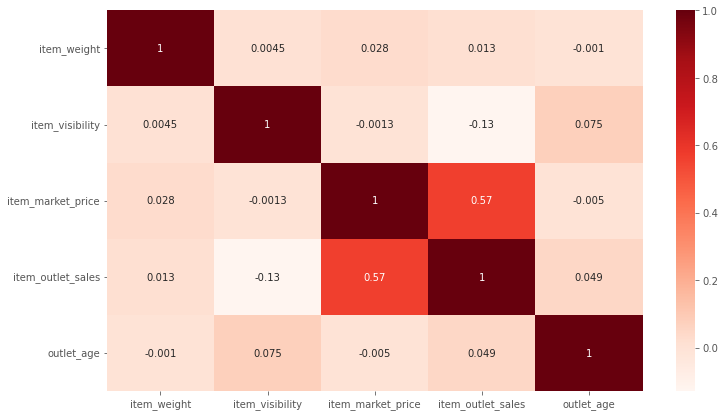

In [44]:
plt.figure(figsize = (12, 7))

sns.heatmap(df.corr(), annot = True, cmap = 'Reds')

**Insights**

- There's a moderate positive correlation between the item market price and item outlet sales , in which  the item market price could help us to predict the future sales.
- Otherwise, there's no correlation with the other variables and it's a good sign to avoid  multicollinearity.
- We have observed that not all the independent variables are important to predict the outcome variable.

# Modeling

At the beginning, we will use all the variables, and then from the model summary, we will decide on which variable to remove from the model. 

Model building is an iterative task.

## #Prepare Data For Modeling

### 1. Define the independent variables and target variable

In [45]:
#define independent variables
ind_vars = df.drop(['item_outlet_sales'], axis = 1)
#define target variable
target_var = df['item_outlet_sales']

###  **2. Encoding categorical features by  creating dummy variables**

In [46]:
def encode_cat_vars_func(x):
    x = pd.get_dummies(x, columns = x.select_dtypes(include = ["object", "category"]).columns.tolist(),
        drop_first = True)
    return x

#apply the function
ind_vars_ = encode_cat_vars_func(ind_vars)
ind_vars_.head(2)

,item_weight,item_visibility,item_market_price,outlet_age,item_fat_Regular,item_category_Breads,item_category_Breakfast,item_category_Canned,item_category_Dairy,item_category_Frozen Foods,...,item_category_Snack Foods,item_category_Soft Drinks,item_category_Starchy Foods,outlet_size_Medium,outlet_size_Small,outlet_location_Tier 2,outlet_location_Tier 3,outlet_type_Supermarket Type1,outlet_type_Supermarket Type2,outlet_type_Supermarket Type3
0,9.30,0.016047,249.8092,24,0,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,0
1,5.92,0.019278,48.2692,14,1,0,0,0,0,0,...,0,1,0,1,0,0,1,0,1,0


### **3. Scaling the numerical features to have the same range**

*If we don't do this, then the model will be biased towards a variable where we have a higher range and the model will not learn from the variables with a lower range.*

In [47]:
def scale_numeric_vars_func(vars_):
    scaler = MinMaxScaler()
    vars_sacled = scaler.fit_transform(vars_)
    vars_sacled = pd.DataFrame(vars_sacled, index = vars_.index, columns = vars_.columns)
    return vars_sacled

ind_vars_sacled = scale_numeric_vars_func(ind_vars_)
ind_vars_sacled.head(2)

,item_weight,item_visibility,item_market_price,outlet_age,item_fat_Regular,item_category_Breads,item_category_Breakfast,item_category_Canned,item_category_Dairy,item_category_Frozen Foods,...,item_category_Snack Foods,item_category_Soft Drinks,item_category_Starchy Foods,outlet_size_Medium,outlet_size_Small,outlet_location_Tier 2,outlet_location_Tier 3,outlet_type_Supermarket Type1,outlet_type_Supermarket Type2,outlet_type_Supermarket Type3
0,0.282525,0.048866,0.927507,0.416667,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.081274,0.058705,0.072068,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


### 4. Split dataset into train-test

In [48]:
Y = target_var
X = ind_vars_sacled

# Splitting the data in 70:30 ratio of train to test data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.30 , random_state = 1)

In [49]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5966, 27), (2557, 27), (5966,), (2557,))

## #Model Building

### 1. Linear Regression 

In [50]:
X_train_scaled = sm.add_constant(X_train)
ols_model_ = sm.OLS(y_train, X_train_scaled)
ols_res_ = ols_model_.fit()
print(ols_res_.summary())

                            OLS Regression Results                            
Dep. Variable:      item_outlet_sales   R-squared:                       0.561
Model:                            OLS   Adj. R-squared:                  0.559
Method:                 Least Squares   F-statistic:                     280.9
Date:                Wed, 09 Aug 2023   Prob (F-statistic):               0.00
Time:                        15:06:20   Log-Likelihood:                -50411.
No. Observations:                5966   AIC:                         1.009e+05
Df Residuals:                    5938   BIC:                         1.011e+05
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

statistically significant or have enough predictive power to predict the target variable, we need to check the `p-value` against all the independent variables.

**Interpreting the Regression Results:**

1. **Adjusted R-squared**: It reflects the fit of the model.
    - R-squared values range from 0 to 1, where a higher value generally indicates a better fit, assuming certain conditions are met.
    - In our case, the value for Adj. R-squared is **0.56**

2. **coef**: It represents the change in the output Y due to a change of one unit in the variable (everything else held constant).
3. **std err**: It reflects the level of accuracy of the coefficients.
    - The lower it is, the more accurate the coefficients are.
4. **P > |t|**: The p-value:
   
   * Pr(>|t|) : For each independent feature there is a null hypothesis and alternate hypothesis 

    **Ho:** Null Hypothesis - The independent feature is not significant 
   
    **Ha:** Alternate Hypothesis - The independent feature is significant 
    
   * A p-value of less than 0.05 is considered to be statistically significant.

   
5. **Confidence Interval**: It represents the range in which our coefficients are likely to fall (with a likelihood of 95%).



* Both the **R-squared and Adjusted R-squared of the model are ~56%**. it means we a moderate model that explains variance in item outlet sales only up to 56%.

* We can examine the significance of the regression model, and try dropping insignificant variables.

### **Checking the Linear Regression Assumptions**


Now, we move on to assumption testing:

1. No Multicollinearity
2. Mean of residuals should be 0
3. No Heteroscedasticity
4. Linearity of variables
5. Normality of error terms

**Checking Assumption 1: No Multicollinearity**

- We will use VIF, to check if there is multicollinearity in the data.

- Features having a VIF score >5 will be dropped/treated till all the features have a VIF score <5.

- We will start to drop the insignificant categorical variables **(item category dummy variables)**..

### **Feature Selection**

In [51]:
train_ind_vars_sacled = X_train_scaled.drop(['item_category_Breads', 'item_category_Breakfast','item_category_Canned', 
                              'item_category_Dairy', 'item_category_Frozen Foods', 'item_category_Fruits and Vegetables',
                              'item_category_Hard Drinks', 'item_category_Health and Hygiene', 'item_category_Household', 
                              'item_category_Meat','item_category_Others', 'item_category_Seafood','item_category_Snack Foods', 
                              'item_category_Soft Drinks', 'item_category_Starchy Foods'], axis=1)

In [52]:
def checking_vif(inds_vars):
    vif = pd.DataFrame()
    vif["feature"] = inds_vars.columns
    vif["VIF"] = [variance_inflation_factor(inds_vars.values, i) for i in range(len(inds_vars.columns))]
    return vif

print(checking_vif(train_ind_vars_sacled))

                          feature          VIF
0                           const  1716.609902
1                     item_weight     1.002179
2                 item_visibility     1.085894
3               item_market_price     1.000899
4                      outlet_age    51.259423
5                item_fat_Regular     1.002757
6              outlet_size_Medium   111.576853
7               outlet_size_Small   107.257574
8          outlet_location_Tier 2    11.336263
9          outlet_location_Tier 3    37.149568
10  outlet_type_Supermarket Type1    29.704051
11  outlet_type_Supermarket Type2    10.076264
12  outlet_type_Supermarket Type3    20.548687


- **outlet_size_Medium** and **outlet_size_Small** are both represent of the same categorical variable and have the highest VIF scores. Hence, we are dropping them and building the model.

In [53]:
train_ind_vars_sacled_1 = train_ind_vars_sacled.drop(['outlet_size_Medium', 'outlet_size_Small'], axis=1)
print(checking_vif(train_ind_vars_sacled_1))

                          feature        VIF
0                           const  38.864220
1                     item_weight   1.001939
2                 item_visibility   1.085683
3               item_market_price   1.000710
4                      outlet_age   5.006965
5                item_fat_Regular   1.002701
6          outlet_location_Tier 2   2.781629
7          outlet_location_Tier 3   2.554118
8   outlet_type_Supermarket Type1   2.819113
9   outlet_type_Supermarket Type2   4.540854
10  outlet_type_Supermarket Type3   2.161907


- Now, let's build the model again and observe the p-values.

In [54]:
ols_model_1 = sm.OLS(y_train, train_ind_vars_sacled_1)
ols_res_1 = ols_model_1.fit()
print(ols_res_1.summary())

                            OLS Regression Results                            
Dep. Variable:      item_outlet_sales   R-squared:                       0.559
Model:                            OLS   Adj. R-squared:                  0.559
Method:                 Least Squares   F-statistic:                     756.0
Date:                Wed, 09 Aug 2023   Prob (F-statistic):               0.00
Time:                        15:06:20   Log-Likelihood:                -50421.
No. Observations:                5966   AIC:                         1.009e+05
Df Residuals:                    5955   BIC:                         1.009e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

- **outlet_location_Tier 3** and **outlet_location_Tier 2** are both represent of the same categorical variable and have the highest VIF scores. Hence, we are dropping them and building the model.

In [55]:
train_ind_vars_sacled_2 = train_ind_vars_sacled_1.drop(['outlet_location_Tier 3', 'outlet_location_Tier 2'], axis=1)
print(checking_vif(train_ind_vars_sacled_2))

                         feature        VIF
0                          const  29.196869
1                    item_weight   1.001640
2                item_visibility   1.084938
3              item_market_price   1.000658
4                     outlet_age   2.175024
5               item_fat_Regular   1.002671
6  outlet_type_Supermarket Type1   2.756111
7  outlet_type_Supermarket Type2   2.659116
8  outlet_type_Supermarket Type3   1.916164


- Again, let's build the model and observe the p-values.

In [56]:
ols_model_2 = sm.OLS(y_train, train_ind_vars_sacled_2)
ols_res_2 = ols_model_2.fit()
print(ols_res_2.summary())

                            OLS Regression Results                            
Dep. Variable:      item_outlet_sales   R-squared:                       0.559
Model:                            OLS   Adj. R-squared:                  0.559
Method:                 Least Squares   F-statistic:                     945.2
Date:                Wed, 09 Aug 2023   Prob (F-statistic):               0.00
Time:                        15:06:21   Log-Likelihood:                -50422.
No. Observations:                5966   AIC:                         1.009e+05
Df Residuals:                    5957   BIC:                         1.009e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

- Now, from the p-values, we can remove the **item_weight** column as it has the highest p-value, i.e., it is the most insignificant variable.

In [57]:
train_ind_vars_sacled_3 = train_ind_vars_sacled_2.drop(['item_weight'], axis=1)
print(checking_vif(train_ind_vars_sacled_3))

                         feature        VIF
0                          const  25.406093
1                item_visibility   1.084935
2              item_market_price   1.000234
3                     outlet_age   2.174984
4               item_fat_Regular   1.001914
5  outlet_type_Supermarket Type1   2.755972
6  outlet_type_Supermarket Type2   2.659052
7  outlet_type_Supermarket Type3   1.915398


- Again, let's build the model and observe the p-values.

In [58]:
ols_model_3 = sm.OLS(y_train, train_ind_vars_sacled_3)
ols_res_3 = ols_model_3.fit()
print(ols_res_3.summary())

                            OLS Regression Results                            
Dep. Variable:      item_outlet_sales   R-squared:                       0.559
Model:                            OLS   Adj. R-squared:                  0.559
Method:                 Least Squares   F-statistic:                     1080.
Date:                Wed, 09 Aug 2023   Prob (F-statistic):               0.00
Time:                        15:06:21   Log-Likelihood:                -50422.
No. Observations:                5966   AIC:                         1.009e+05
Df Residuals:                    5958   BIC:                         1.009e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

- Now, from the p-values, we can remove the **outlet_age** column as it has the highest p-value, i.e., it is the most insignificant variable.

In [59]:
train_ind_vars_sacled_4 = train_ind_vars_sacled_3.drop(['outlet_age'], axis=1)
print(checking_vif(train_ind_vars_sacled_4))

                         feature        VIF
0                          const  16.189917
1                item_visibility   1.084923
2              item_market_price   1.000233
3               item_fat_Regular   1.001885
4  outlet_type_Supermarket Type1   2.352700
5  outlet_type_Supermarket Type2   1.753189
6  outlet_type_Supermarket Type3   1.780074


- Again, let's build the model and observe the p-values.

In [60]:
ols_model_4 = sm.OLS(y_train, train_ind_vars_sacled_4)
ols_res_4 = ols_model_4.fit()
print(ols_res_4.summary())

                            OLS Regression Results                            
Dep. Variable:      item_outlet_sales   R-squared:                       0.559
Model:                            OLS   Adj. R-squared:                  0.559
Method:                 Least Squares   F-statistic:                     1260.
Date:                Wed, 09 Aug 2023   Prob (F-statistic):               0.00
Time:                        15:06:21   Log-Likelihood:                -50422.
No. Observations:                5966   AIC:                         1.009e+05
Df Residuals:                    5959   BIC:                         1.009e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

- Now, from the p-values, we can remove the **item_visibility** column as it has the highest p-value, i.e., it is the most insignificant variable.

In [61]:
train_ind_vars_sacled_5 = train_ind_vars_sacled_4.drop(['item_visibility'], axis=1)
print(checking_vif(train_ind_vars_sacled_5))

                         feature        VIF
0                          const  11.802676
1              item_market_price   1.000218
2               item_fat_Regular   1.000153
3  outlet_type_Supermarket Type1   2.180605
4  outlet_type_Supermarket Type2   1.685592
5  outlet_type_Supermarket Type3   1.694510


- Again, let's build the model and observe the p-values.

In [62]:
ols_model_5 = sm.OLS(y_train, train_ind_vars_sacled_5)
ols_res_5 = ols_model_5.fit()
print(ols_res_5.summary())

                            OLS Regression Results                            
Dep. Variable:      item_outlet_sales   R-squared:                       0.559
Model:                            OLS   Adj. R-squared:                  0.559
Method:                 Least Squares   F-statistic:                     1512.
Date:                Wed, 09 Aug 2023   Prob (F-statistic):               0.00
Time:                        15:06:21   Log-Likelihood:                -50423.
No. Observations:                5966   AIC:                         1.009e+05
Df Residuals:                    5960   BIC:                         1.009e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

- Finally, from the p-values, we can remove the  last column  **item_fat_Regular** as it has a high p-value.

In [63]:
train_ind_vars_sacled_6 = train_ind_vars_sacled_5.drop(['item_fat_Regular'], axis=1)
print(checking_vif(train_ind_vars_sacled_6))

                         feature        VIF
0                          const  11.241958
1              item_market_price   1.000218
2  outlet_type_Supermarket Type1   2.180550
3  outlet_type_Supermarket Type2   1.685588
4  outlet_type_Supermarket Type3   1.694457


In [64]:
ols_model_6 = sm.OLS(y_train, train_ind_vars_sacled_6)
ols_res_6 = ols_model_6.fit()
print(ols_res_6.summary())

                            OLS Regression Results                            
Dep. Variable:      item_outlet_sales   R-squared:                       0.559
Model:                            OLS   Adj. R-squared:                  0.559
Method:                 Least Squares   F-statistic:                     1889.
Date:                Wed, 09 Aug 2023   Prob (F-statistic):               0.00
Time:                        15:06:21   Log-Likelihood:                -50424.
No. Observations:                5966   AIC:                         1.009e+05
Df Residuals:                    5961   BIC:                         1.009e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

**Insights**

- All the VIF Scores are now less than 5 indicating no multicollinearity.
- Now, all the p values are lesser than 0.05 implying all the current variables are significant for the model.
- The R-Squared value **0.55** did drop a little compared to the base model..

Lets' check the assumptions of the linear regression model.

## **Checking for the assumptions and rebuilding the model**

In this step, we will check whether the below assumptions hold true or not for the model. In case there is an issue, we will rebuild the model after fixing those issues.

1. Mean of residuals should be 0
2. Normality of error terms
3. Linearity of variables
4. No heteroscedasticity

**Mean of residuals should be 0 and normality of error terms**

In [65]:
residual = ols_res_6.resid 
residual.mean()

-1.2500597644213898e-12

- The mean of residuals is very close to 0. Hence, the corresponding assumption is satisfied.

**Tests for Normality**

**What is the test?**

* Error terms/Residuals should be normally distributed.

* If the error terms are non-normally distributed, confidence intervals may become too wide or narrow. Once the confidence interval becomes unstable, it leads to difficulty in estimating coefficients based on the minimization of least squares.

**What does non-normality indicate?**

* It suggests that there are a few unusual data points that must be studied closely to make a better model.

**How to check the normality?**

* We can plot the histogram of residuals and check the distribution visually.

* It can be checked via QQ Plot. Residuals following normal distribution will make a straight line plot otherwise not.

* Another test to check for normality: The Shapiro-Wilk test.

**What if the residuals are not-normal?**

* We can apply transformations like log, exponential, arcsinh, etc. as per our data.

<AxesSubplot:ylabel='Count'>

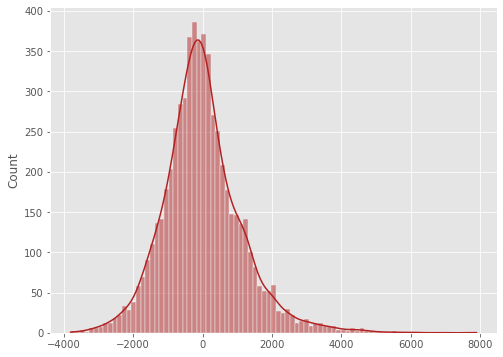

In [66]:
plt.figure(figsize = (8,6))
sns.histplot(residual, kde = True, color='#B22222')

- We can see that the error terms are normally distributed. The assumption of normality is satisfied.

**Linearity of Variables**

It states that the predictor variables must have a linear relation with the dependent variable.

To test this assumption, we'll plot the residuals and the fitted values and ensure that residuals do not form a strong pattern. They should be randomly and uniformly scattered on the x-axis.

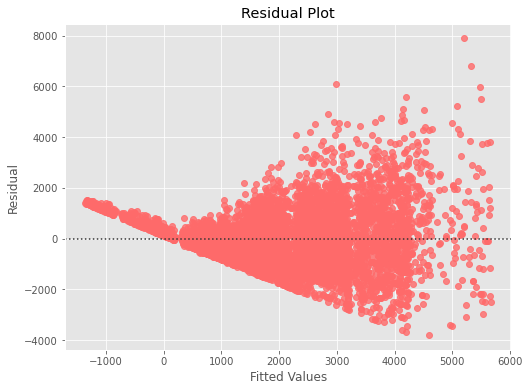

In [67]:
fitted = ols_res_6.fittedvalues

plt.figure(figsize = (8,6))
sns.residplot(x=fitted, y=residual, color='#FF6A6A')
plt.xlabel('Fitted Values')
plt.ylabel('Residual')
plt.title('Residual Plot', fontsize=14.5)
plt.show()

**Insights**

- We can see that there is a kind of pattern in fitted values and residuals, i.e., the residuals are not randomly distributed.
- Let's try to fix this. We can apply the log transformation on the target variable and try to build a new model.

In [68]:
train_target_var_log = np.log(y_train)

In [69]:
ols_model_7 = sm.OLS(train_target_var_log, train_ind_vars_sacled_6)
ols_res_7 = ols_model_7.fit()
print(ols_res_7.summary())

                            OLS Regression Results                            
Dep. Variable:      item_outlet_sales   R-squared:                       0.716
Model:                            OLS   Adj. R-squared:                  0.716
Method:                 Least Squares   F-statistic:                     3756.
Date:                Wed, 09 Aug 2023   Prob (F-statistic):               0.00
Time:                        15:06:21   Log-Likelihood:                -4773.6
No. Observations:                5966   AIC:                             9557.
Df Residuals:                    5961   BIC:                             9591.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

**Insight**

- The model performance has improved significantly. The R-Squared has increased from ***0.55 to 0.71***.

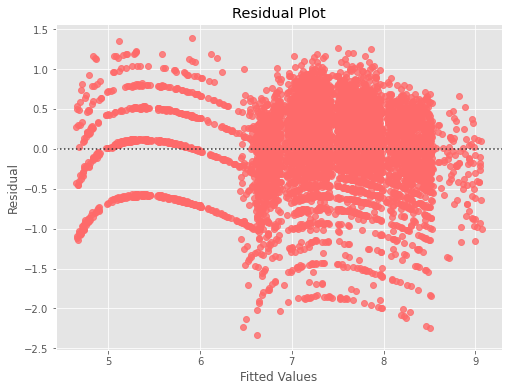

In [70]:
fitted = ols_res_7.fittedvalues
residual_1 = ols_res_7.resid

plt.figure(figsize = (8,6))
sns.residplot(x = fitted, y = residual_1, color = '#FF6A6A')
plt.xlabel('Fitted Values')
plt.ylabel('Residual')
plt.title('Residual Plot', fontsize=14.5)
plt.show()

**Insights**

- We can see that there is no pattern in the residuals vs fitted values scatter plot now, i.e., the linearity assumption is satisfied.
- Let's check the model summary of the latest model we have fit. 

**No Heteroscedasticity**


**Test for Homoscedasticity**

* **Homoscedasticity -** If the variance of the residuals are symmetrically distributed across the regression line, then the data is said to homoscedastic.

* **Heteroscedasticity -** If the variance is unequal for the residuals across the regression line, then the data is said to be heteroscedastic. In this case, the residuals can form an arrow shape or any other non symmetrical shape.

- We will use Goldfeld–Quandt test to check homoscedasticity.

    - **Null hypothesis** : Residuals are homoscedastic

    - **Alternate hypothesis** : Residuals are hetroscedastic

In [71]:
#import packages
from statsmodels.stats.diagnostic import het_white
from statsmodels.compat import lzip
import statsmodels.stats.api as sms
import statsmodels.stats.api as sms


#perform the test
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(train_target_var_log, train_ind_vars_sacled_6)
lzip(name, test)

[('F statistic', 0.9876599533951455), ('p-value', 0.6326084518922641)]

- As we observe from the above test, the p-value is greater than 0.05, so we fail to reject the null-hypothesis. That means the residuals are homoscedastic.

### #**Predictions**

In [72]:
X_test_scaled = sm.add_constant(X_test)
test_target_var_log = np.log(y_test)

In [73]:
X_test_scaled = X_test_scaled.drop(['item_category_Breads', 'item_category_Breakfast','item_category_Canned', 
                              'item_category_Dairy', 'item_category_Frozen Foods', 'item_category_Fruits and Vegetables',
                              'item_category_Hard Drinks', 'item_category_Health and Hygiene', 'item_category_Household', 
                              'item_category_Meat','item_category_Others', 'item_category_Seafood','item_category_Snack Foods', 
                              'item_category_Soft Drinks', 'item_category_Starchy Foods', 'item_weight', 'outlet_size_Medium', 'outlet_size_Small', 'outlet_location_Tier 3',
                              'outlet_location_Tier 2', 'item_weight', 'outlet_age', 'item_fat_Regular', 'item_visibility'], axis=1)
X_test_scaled.head(2)

,const,item_market_price,outlet_type_Supermarket Type1,outlet_type_Supermarket Type2,outlet_type_Supermarket Type3
1070,1.0,0.024607,1.0,0.0,0.0
6305,1.0,0.240366,0.0,1.0,0.0


In [74]:
test_predictions = ols_res_7.predict(X_test_scaled)
# We are converting the log scale predictions to its original scale
test_predictions_inverse_transformed = np.exp(test_predictions)
test_predictions_inverse_transformed.head()

1070     767.756676
6305     987.078193
8504    2446.897153
5562    1160.113670
1410     791.951612
dtype: float64

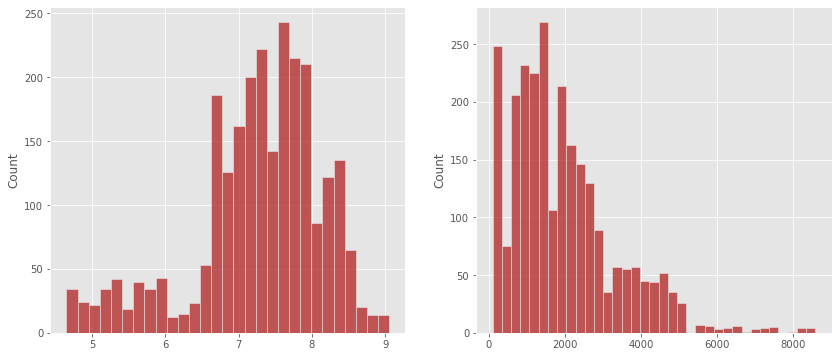

In [75]:
fig, ax = plt.subplots(1, 2, figsize = (14, 6))
sns.histplot(test_predictions, ax = ax[0], color='#B22222');
sns.histplot(test_predictions_inverse_transformed, ax = ax[1], color='#B22222');

### #**Model Evaluation Metrics**


*Below, we are checking the cross-validation score to identify if the model that we have built is **underfitted**, **overfitted** or **just right fit** model.*

In [76]:
def cv_score_func(predictors, target):
    
    linearregression = LinearRegression()                                    
    
    cv_Score11 = cross_val_score(linearregression, predictors, target, cv = 10)
    cv_Score12 = cross_val_score(linearregression, predictors, target, cv = 10, scoring = 'neg_mean_squared_error')                                  
    
    print("R-Squared: {} (+/- {})".format(round(cv_Score11.mean(), 3), round(cv_Score11.std()*2, 3)))
    print("Mean Squared Error: {} (+/- {})".format(round(-1*cv_Score12.mean(), 3), round(cv_Score12.std()*2, 3)))
     

In [77]:
cv_score_func(train_ind_vars_sacled_6, train_target_var_log)

R-Squared: 0.715 (+/- 0.02)
Mean Squared Error: 0.291 (+/- 0.043)


In [78]:
cv_score_func(X_test_scaled, test_target_var_log)

R-Squared: 0.724 (+/- 0.06)
Mean Squared Error: 0.29 (+/- 0.065)


In [79]:
def mse_func(predictions, targets):
    return mean_squared_error(targets, predictions)


def rmse_func(predictions, targets):
    return np.sqrt(mean_squared_error(targets, predictions))

def mape_func(predictions, targets):
    return np.mean(np.abs((targets - predictions)) / targets) * 100

def mae_func(predictions, targets):
    return mean_absolute_error(targets, predictions) 

def r2_score_func(predictions, targets):
    return r2_score(targets, predictions)


def adj_r2_score_func(predictors, targets, predictions):
    r2 = r2_score(targets, predictions)
    n = predictors.shape[0]
    k = predictors.shape[1]
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))


def model_perf_regression_func(model, x_train, x_test, y_train, y_test):

    y_pred_train = model.predict(x_train)
    y_observed_train = y_train

    y_pred_test = model.predict(x_test)
    y_observed_test = y_test

    df_perf = pd.DataFrame(
        {
            "Dataset": ["Train", "Test"],
            "MSE" :[
                mse_func(y_pred_train, y_observed_train),
                mse_func(y_pred_test, y_observed_test),
            ],
            "RMSE":[    
                rmse_func(y_pred_train, y_observed_train),
                rmse_func(y_pred_test, y_observed_test),
                ],
            "MAE": [
                mae_func(y_pred_train, y_observed_train),
                mae_func(y_pred_test, y_observed_test),
                ],
            "R-squared": [
                r2_score_func(y_pred_train, y_observed_train),
                r2_score_func(y_pred_test, y_observed_test),
            ],
            "Adj. R-squared": [
                adj_r2_score_func(x_train, y_pred_train, y_observed_train),
                adj_r2_score_func(x_test, y_pred_test, y_observed_test),
            ],
            "MAPE": [
                mape_func(y_pred_train, y_observed_train),
                mape_func(y_pred_test, y_observed_test),
            ]
        },
        
    )

    return df_perf

In [80]:
#Checking model performance
lin_perf = model_perf_regression_func(ols_res_7, train_ind_vars_sacled_6, X_test_scaled, train_target_var_log, test_target_var_log)
lin_perf

,Dataset,MSE,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,Train,0.290078,0.538589,0.416804,0.715935,0.602893,6.063675
1,Test,0.289834,0.538363,0.420230,0.727759,0.627252,6.111596


**Insight**

- The **R-Squared** on the cross-validation of the test dataset is **0.727** which is almost similar to the **R-Squared** of the train dataset **0.715**.

- The **MSE** on cross-validation of the test dataset is **0.290** which is almost similar to the **MSE** of the  train dataset **0.291**.

- **RMSE, MAE, and MAPE** of train and test data are not very different, indicating that the **model is not overfitting and It seems like that our model is just right fit. It is giving a generalized performance..**

### 2. Ridge Regression

In [81]:
rdg = Ridge()

In [82]:
rdg.fit(X_train, train_target_var_log)
rdg_perf = model_perf_regression_func(rdg, X_train, X_test, train_target_var_log, test_target_var_log)
rdg_perf

,Dataset,MSE,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,Train,0.288385,0.537015,0.415692,0.717593,0.601637,6.046957
1,Test,0.289945,0.538465,0.420201,0.727656,0.623550,6.109269


**Insights**

- It seems **Ridge regression** produces similar performance results as **Linear Regression**.
- **RMSE** of train and test data is **not different**, indicating that **our model is not overfitting** to the training data.
- **MAE** indicates that our current model is able to predict the sales within **mean error of 0.41 USD** on the test data.
- **Mean Absolute Percentage Error is 6%** on the test data.

The units of both RMSE and MAE are same - USD in this case. But RMSE is greater than MAE because it penalizes the outliers more.

### **Business Insights and Recommendations**

below is the model equation:

**$\log ($ item_outlet_sales $)$ $= 4.6357 + 1.9438 *$ item_market_price$ + 1.9600 *$ outlet_type_Supermarket Type1 $ + 1.7918 *$ outlet_type_Supermarket Type2$ + 2.5030*$ outlet_type_Supermarket Type3**


- From the above equation, we can interpret that, with one unit change in the variable **item_market_price**, the outcome variable, i.e., log of **item_outlet_sales** increases by 1.9438 units. So, if we want to increase the sales, we may want to store higher market price items in the high visibility area.

- On average, keeping other factors constant, the log sales of stores with type Supermarket type 3 are 1.4 (2.5030/1.7918) times the log sales of stores with type 2 and 1.27 (2.5030/1.9600) times the log sales of those stores with type 1.


After interpreting this linear regression equation, it is clear that large stores of supermarket type 3 have more sales than other types of outlets. So, we want to maintain or improve the sales in these stores and for the remaining ones, we may want to make strategies to improve the sales, for example, providing better customer service, better training for store staff,  providing more visibility of the items that have high market price , etc.

### 3. Decision Tree Regressor


Since the models that we have developed above are linear models which are not capable of capturing non-linear patterns in the data, we want to build more advanced regression models which can capture the non-linearities in the data and improve performance further.

In [83]:
X1 = ind_vars_
Y1 = np.log(df['item_outlet_sales'])

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X1, Y1, test_size = 0.30 , random_state = 1)

dt = DecisionTreeRegressor(min_samples_split = 2)
dt.fit(X_train_1, y_train_1)

DecisionTreeRegressor()

In [84]:
dt_perf = model_perf_regression_func(dt, X_train_1, X_test_1, y_train_1, y_test_1)
dt_perf

,Dataset,MSE,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,Train,0.000000,0.00000,0.000000,1.000000,1.000000,0.000000
1,Test,0.544097,0.73763,0.569493,0.488931,0.491622,8.215568


**Insight**

- The model seem to **overfit** the data by giving almost 100% result of the train dataset and with errors on the test dataset.

**Tuning the Decision Tree Regressor**

In [85]:
dt_tuned = DecisionTreeRegressor()

parameters = {'max_depth': np.arange(2,8), 
              'criterion': ['squared_error', 'friedman_mse'],
              'min_samples_leaf': [1, 3, 5, 7],
              'max_leaf_nodes' : [2, 5, 7] + [None]
             }

scorer = make_scorer(r2_score)

grid_obj = GridSearchCV(dt_tuned, parameters, scoring=scorer, cv=5)
grid_obj = grid_obj.fit(X_train_1, y_train_1)

dt_tuned_regressor = grid_obj.best_estimator_

dt_tuned_regressor.fit(X_train_1, y_train_1)

DecisionTreeRegressor(criterion='friedman_mse', max_depth=6, min_samples_leaf=3)

In [86]:
dt_tuned_perf = model_perf_regression_func(dt_tuned_regressor, X_train_1, X_test_1, y_train_1, y_test_1)
dt_tuned_perf

,Dataset,MSE,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,Train,0.256911,0.506864,0.390059,0.748415,0.662314,5.662706
1,Test,0.276275,0.525619,0.412585,0.740495,0.659977,5.977843


- Now, the model is giving a generalized performance.

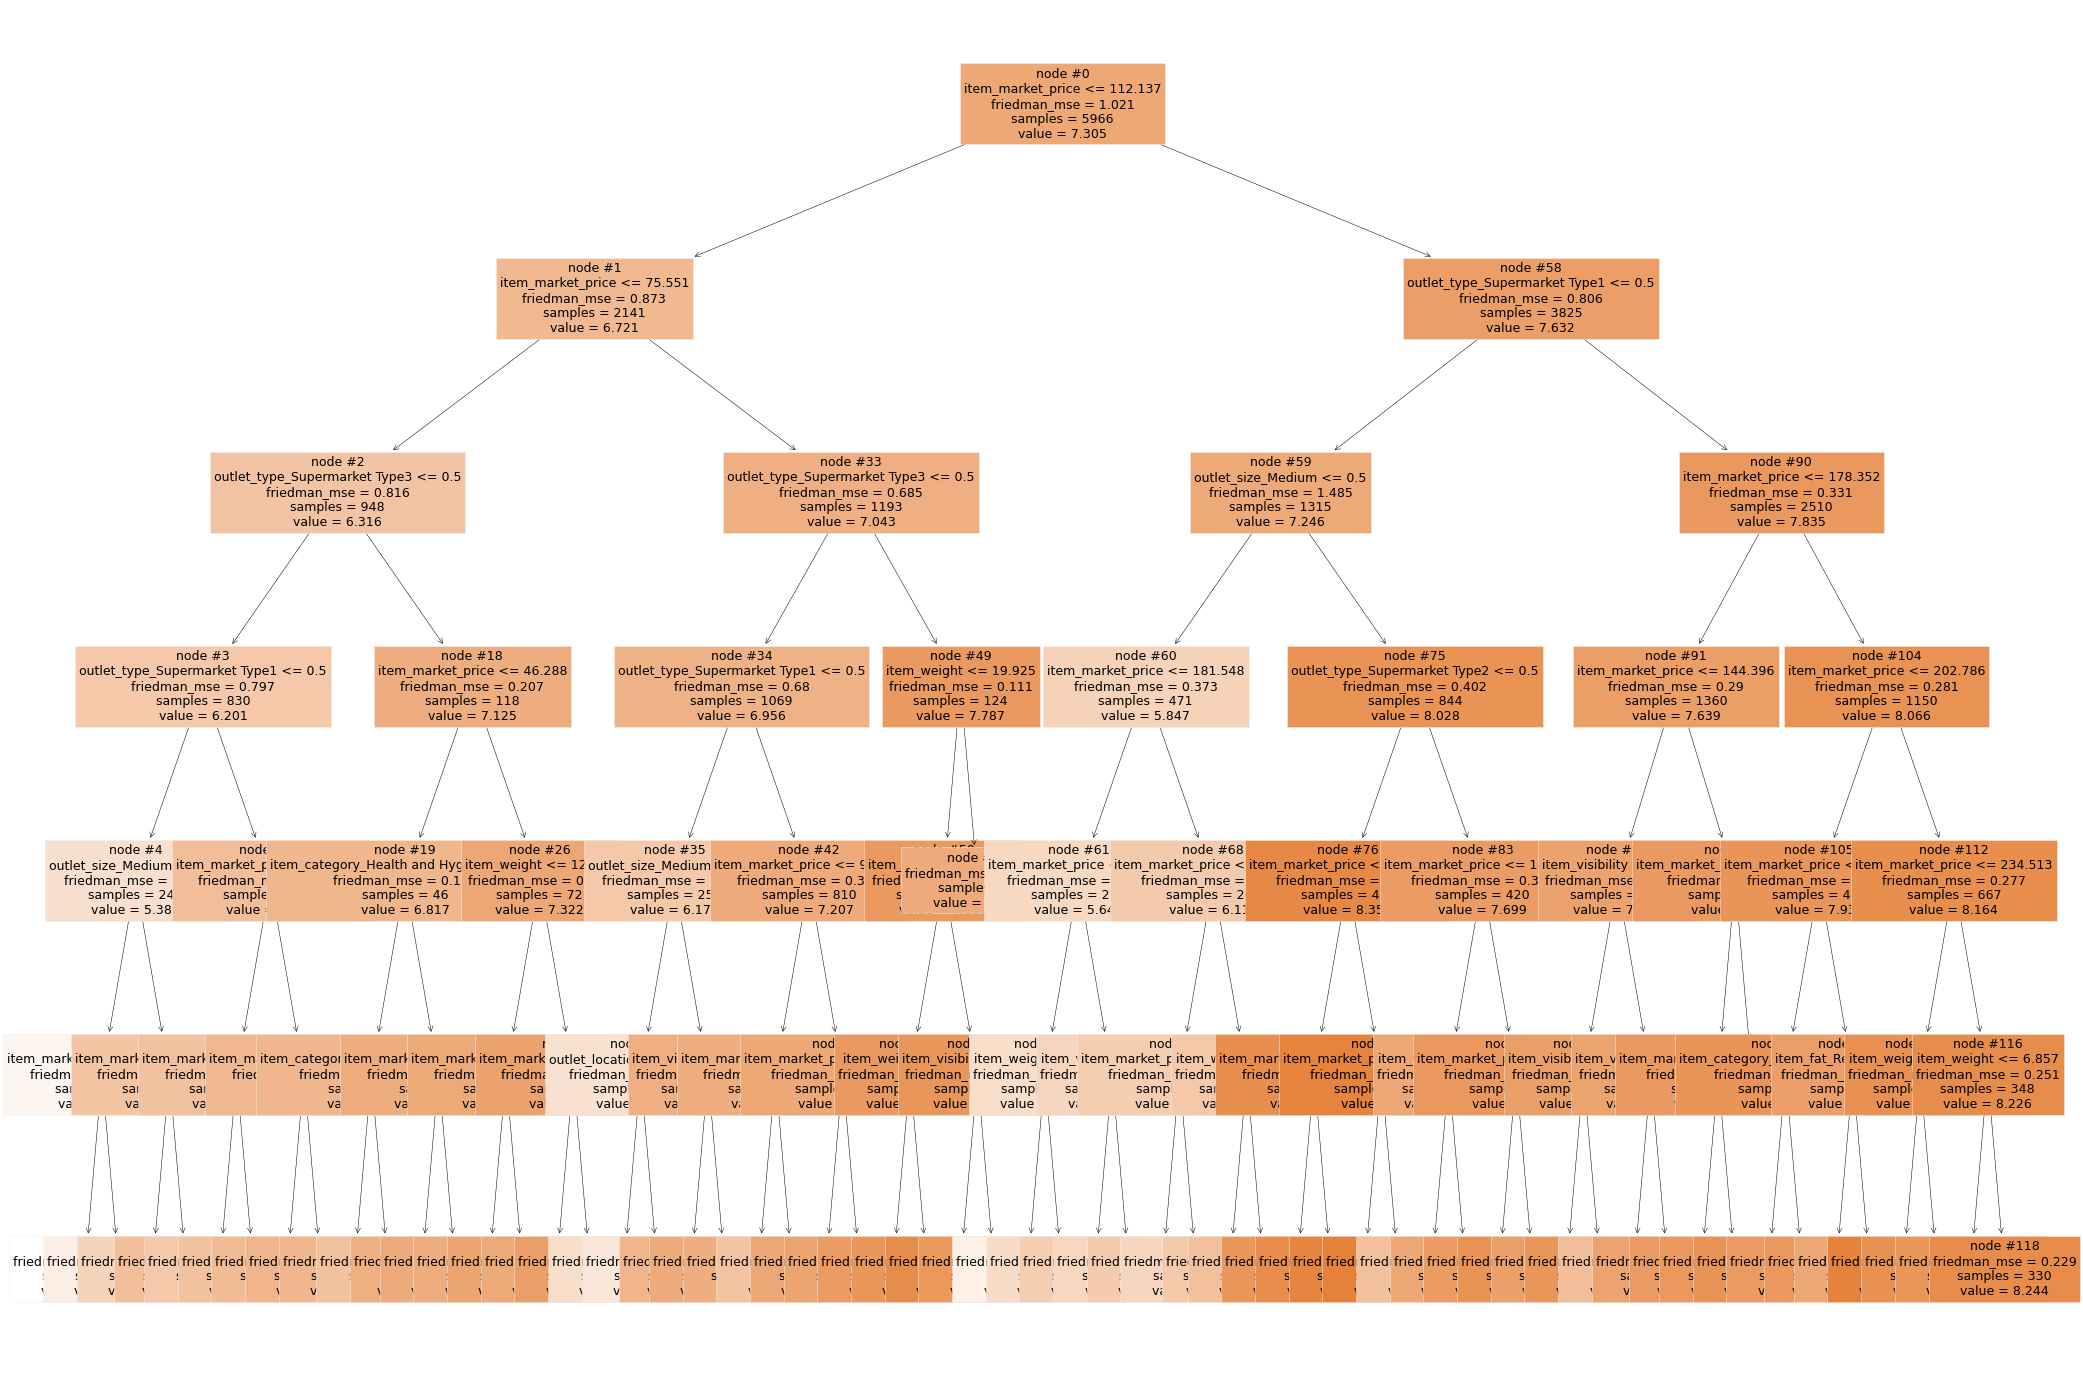

In [87]:
features = list(X1.columns)

plt.figure(figsize = (35, 25))
plot_tree(dt_tuned_regressor, max_depth = 6, feature_names = features, filled = True, fontsize = 12.5, node_ids = True, class_names = True)
plt.show()

Text(0.5, 0, 'Relative Importance')

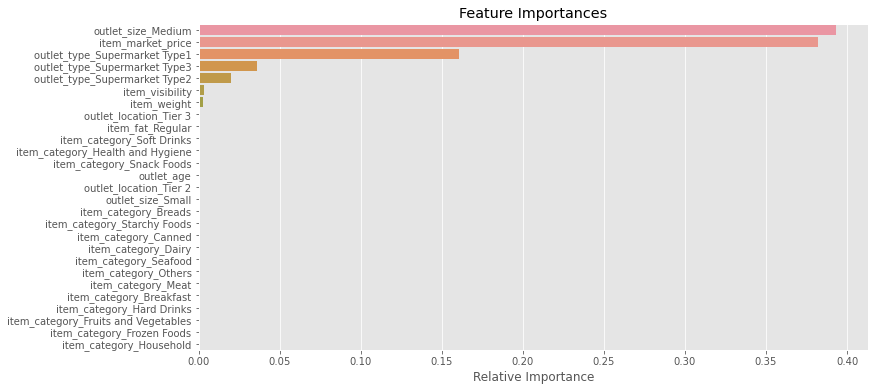

In [88]:
importances = dt_tuned_regressor.feature_importances_
columns = X1.columns
importance_df = pd.DataFrame(importances, index = columns, columns = ['importance']).sort_values(by = 'importance', ascending = False)#.head(5)
plt.figure(figsize = (12, 6))
sns.barplot(importance_df.importance,importance_df.index)
plt.title('Feature Importances')
plt.xlabel('Relative Importance')

**Insights**

- The most important features that affect the sales are **item market price, outlet size, and outlet type.**

### 4. Bagging Regressor

In [89]:
bagging_estimator = BaggingRegressor()

bagging_estimator.fit(X_train_1, y_train_1)

bagging_perf = model_perf_regression_func(bagging_estimator, X_train_1, X_test_1, y_train_1, y_test_1)
bagging_perf

,Dataset,MSE,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,Train,0.058933,0.242760,0.176170,0.942289,0.933273,2.537408
1,Test,0.325068,0.570148,0.444158,0.694664,0.628241,6.407688


- It seems the model is **overfit**.

**Tuned Bagging Regressor** 

In [90]:
bagging_tuned = BaggingRegressor()

parameters = {"n_estimators": [10,15,20],
              "max_samples" : [0.8,1],
              "max_features" : [0.8,1]
             }

scorer = make_scorer(r2_score)

grid_obj = GridSearchCV(bagging_tuned , parameters, scoring=scorer,cv=5)
grid_obj = grid_obj.fit(X_train_1, y_train_1)

bagging_tuned_regressor = grid_obj.best_estimator_

bagging_tuned_regressor.fit(X_train_1, y_train_1)

BaggingRegressor(max_features=0.8, max_samples=0.8, n_estimators=20)

In [91]:
bagging_tuned_regressor_perf = model_perf_regression_func(bagging_tuned_regressor, X_train_1, X_test_1, y_train_1, y_test_1)
bagging_tuned_regressor_perf

,Dataset,MSE,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,Train,0.084519,0.290721,0.222954,0.917233,0.888102,3.230416
1,Test,0.318840,0.564659,0.441789,0.700515,0.542316,6.415675


### 5. **Random Forest Regressor**

In [92]:
regressor = RandomForestRegressor(n_estimators = 100)
regressor.fit(X_train_1, y_train_1)

RandomForestRegressor()

In [93]:
rf_perf = model_perf_regression_func(regressor, X_train_1, X_test_1, y_train_1, y_test_1)
rf_perf

,Dataset,MSE,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,Train,0.042023,0.204995,0.158895,0.958848,0.951131,2.298905
1,Test,0.299806,0.547546,0.430766,0.718393,0.636962,6.221606


- The model seem to **overfit**.

**Tuned Random Forest Regressor**

In [94]:
rf_tuned = RandomForestRegressor()

parameters = {"n_estimators": [110, 120],
    "max_depth": [5, 7],
    "max_features": [0.8, 1]
             }

scorer = make_scorer(r2_score)

grid_obj = GridSearchCV(rf_tuned, parameters, scoring=scorer,cv=5)
grid_obj = grid_obj.fit(X_train_1, y_train_1)

rf_tuned_regressor = grid_obj.best_estimator_
rf_tuned_regressor.fit(X_train_1, y_train_1)

RandomForestRegressor(max_depth=5, max_features=0.8, n_estimators=120)

In [95]:
rf_tuned_regressor_perf = model_perf_regression_func(rf_tuned_regressor, X_train_1, X_test_1, y_train_1, y_test_1)
rf_tuned_regressor_perf

,Dataset,MSE,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,Train,0.263716,0.513533,0.396299,0.741751,0.619687,5.770269
1,Test,0.272025,0.521560,0.408553,0.744488,0.629900,5.950591


- The performance of the tuned model is actually better than compared to the model with default parameters. 

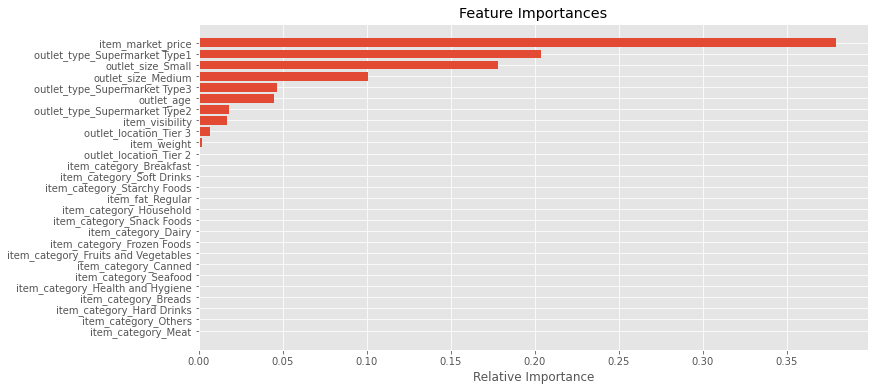

In [96]:
importances = rf_tuned_regressor.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

**Insights**

- The top 3 important variables are the same as decision tree model.

### **Business Insights and Recommendations**

- As seen above, the market price of items is **the most important variable that adds value to our models** and which affects the sales of the outlets, as outlets where the high item market prices tend to have a higher sales.

- Other important features is **outlet type and outlet size**. These two variables collectively signify that outlets can generate higher sales where the type of the outlet is **Supermarket Type 1**, and outlet size is **Small** where the items market prices tend to be higher than the others.


With the linear models we observed that the outlets in the supermarket type 3 have higher sales than the other outlets, however, with bagging models we also came up with another interesting insight that it is clear that outlets of type supermarket type 1 that outlet size is small have more of the high market price than other types of outlets. And we know that the high market prices of the items can lead to increased sales, hence, if we want to improve the sales, we should focus on these stores and provide more visibility of the items that have high market price to encourage the customers to buy more of these items.

### 6. Adaboost Regressor

In [97]:
adaboost_model = AdaBoostRegressor()
adaboost_model.fit(X_train_1, y_train_1)
adaboost_model_pref = model_perf_regression_func(adaboost_model, X_train_1, X_test_1, y_train_1, y_test_1)
adaboost_model_pref

,Dataset,MSE,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,Train,0.424855,0.651809,0.548615,0.583952,0.050873,7.718311
1,Test,0.434059,0.658831,0.557931,0.592290,0.081458,7.866814


- The model is just right fit and has generalized performance.

### 7. Gradient Boosting Regressor

In [98]:
gbc = GradientBoostingRegressor()
gbc.fit(X_train_1, y_train_1)
gbc_perf = model_perf_regression_func(gbc, X_train_1, X_test_1, y_train_1, y_test_1)
gbc_perf

,Dataset,MSE,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,Train,0.251852,0.501849,0.388256,0.753368,0.655404,5.639663
1,Test,0.270601,0.520194,0.408015,0.745825,0.647203,5.930145


- The model is just right fit and has generalized performance.

### #Model Performance Comparison

In [99]:
models_comp_df = pd.concat(
    [
        lin_perf.T,
        rdg_perf.T,
        dt_perf.T,
        rf_perf.T,
        bagging_perf.T,
        dt_tuned_perf.T,
        bagging_tuned_regressor_perf.T,
        rf_tuned_regressor_perf.T,
        adaboost_model_pref.T,
        gbc_perf.T
    ],
    axis=1,
    ignore_index = False,
)

models_comp_df.columns = [
    "Linear Regression(train)",
    "Linear Regression(test)",
    "Ridge Regression(train)",
    "Ridge Regression(test)",
    "Decision tree regressor(train)",
    "Decision tree regressor(test)",
    "Random Forest regressor(train)",
    "Random Forest regressor(test)",
    "Bagging regressor(train)",
    "Bagging regressor(test)",
    "Tuned Decision Tree regressor(train)",
    "Tuned Decision Tree regressor(test)",
    "Tuned Bagging Tree regressor(train)",
    "Tuned Bagging Tree regressor(test)",
    "Tuned Random Forest Regressor(train)",
    "Tuned Random Forest Regressor(test)",
    "Adaboost Regressor(train)",
    "Adaboost Regressor(test)",
    "Gradient Boosting Regressor(train)",
    "Gradient Boosting Regressor(test)"]

models_comp_df.drop(index=models_comp_df.index[0], axis=0, inplace=True)
models_comp_df

,Linear Regression(train),Linear Regression(test),Ridge Regression(train),Ridge Regression(test),Decision tree regressor(train),Decision tree regressor(test),Random Forest regressor(train),Random Forest regressor(test),Bagging regressor(train),Bagging regressor(test),Tuned Decision Tree regressor(train),Tuned Decision Tree regressor(test),Tuned Bagging Tree regressor(train),Tuned Bagging Tree regressor(test),Tuned Random Forest Regressor(train),Tuned Random Forest Regressor(test),Adaboost Regressor(train),Adaboost Regressor(test),Gradient Boosting Regressor(train),Gradient Boosting Regressor(test)
MSE,0.290078,0.289834,0.288385,0.289945,0.0,0.544097,0.042023,0.299806,0.058933,0.325068,0.256911,0.276275,0.084519,0.31884,0.263716,0.272025,0.424855,0.434059,0.251852,0.270601
RMSE,0.538589,0.538363,0.537015,0.538465,0.0,0.73763,0.204995,0.547546,0.24276,0.570148,0.506864,0.525619,0.290721,0.564659,0.513533,0.52156,0.651809,0.658831,0.501849,0.520194
MAE,0.416804,0.42023,0.415692,0.420201,0.0,0.569493,0.158895,0.430766,0.17617,0.444158,0.390059,0.412585,0.222954,0.441789,0.396299,0.408553,0.548615,0.557931,0.388256,0.408015
R-squared,0.715935,0.727759,0.717593,0.727656,1.0,0.488931,0.958848,0.718393,0.942289,0.694664,0.748415,0.740495,0.917233,0.700515,0.741751,0.744488,0.583952,0.59229,0.753368,0.745825
Adj. R-squared,0.602893,0.627252,0.601637,0.62355,1.0,0.491622,0.951131,0.636962,0.933273,0.628241,0.662314,0.659977,0.888102,0.542316,0.619687,0.6299,0.050873,0.081458,0.655404,0.647203
MAPE,6.063675,6.111596,6.046957,6.109269,0.0,8.215568,2.298905,6.221606,2.537408,6.407688,5.662706,5.977843,3.230416,6.415675,5.770269,5.950591,7.718311,7.866814,5.639663,5.930145


### **Conclusion**

- In terms of accuracy measurement of the predictions, the linear models have the same RMSE. The best RMSE measure is for the tuned random forest regressor model and gradient boosting regressor which have ***the lowest RMSE***, while the decision tree regressor model has the worst ***RMSE value higher than the other models***, which means this model is obviously overfitting and unable to give a generalized performance.

- In terms of variation, the linear models have the same R2. The best models are the tuned random forest regressor and gradient boosting regressor which are able to ***explain ~75% of the variation in the data***, while the decision tree regressor model explains the least variation in the data.

- Overall, ***The Tuned Random Forest Regressor and Gradient Boosting Regressor*** give the best performance for this dataset.